In [207]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [208]:
table = pd.read_csv('train.csv')
# table.info()
table.isna().sum()

ApplicationDate                530
Age                            530
AnnualIncome                   530
CreditScore                   1031
LoanAmount                    1031
LoanDuration                   530
MaritalStatus                  530
NumberOfDependents             530
HomeOwnershipStatus            530
MonthlyDebtPayments           1031
CreditCardUtilizationRate      530
NumberOfOpenCreditLines        530
NumberOfCreditInquiries        530
DebtToIncomeRatio              530
BankruptcyHistory             1031
LoanPurpose                   1031
PreviousLoanDefaults           530
PaymentHistory                 530
LengthOfCreditHistory          530
SavingsAccountBalance          530
CheckingAccountBalance        1031
TotalAssets                   1031
TotalLiabilities               530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
JobTenure                      530
EmploymentStatus               530
EducationLevel                 530
Experience          

Рассмотрим количество пропусков в датафрейме. Как мы видим, их количество в каждой из колонок не превышает 1031, что означает, что по большому счёту от них можно просто избавиться, поскольку в датафрейме гораздо больше значений и удаление строк с пропусками мало на что повлияет.

<Axes: >

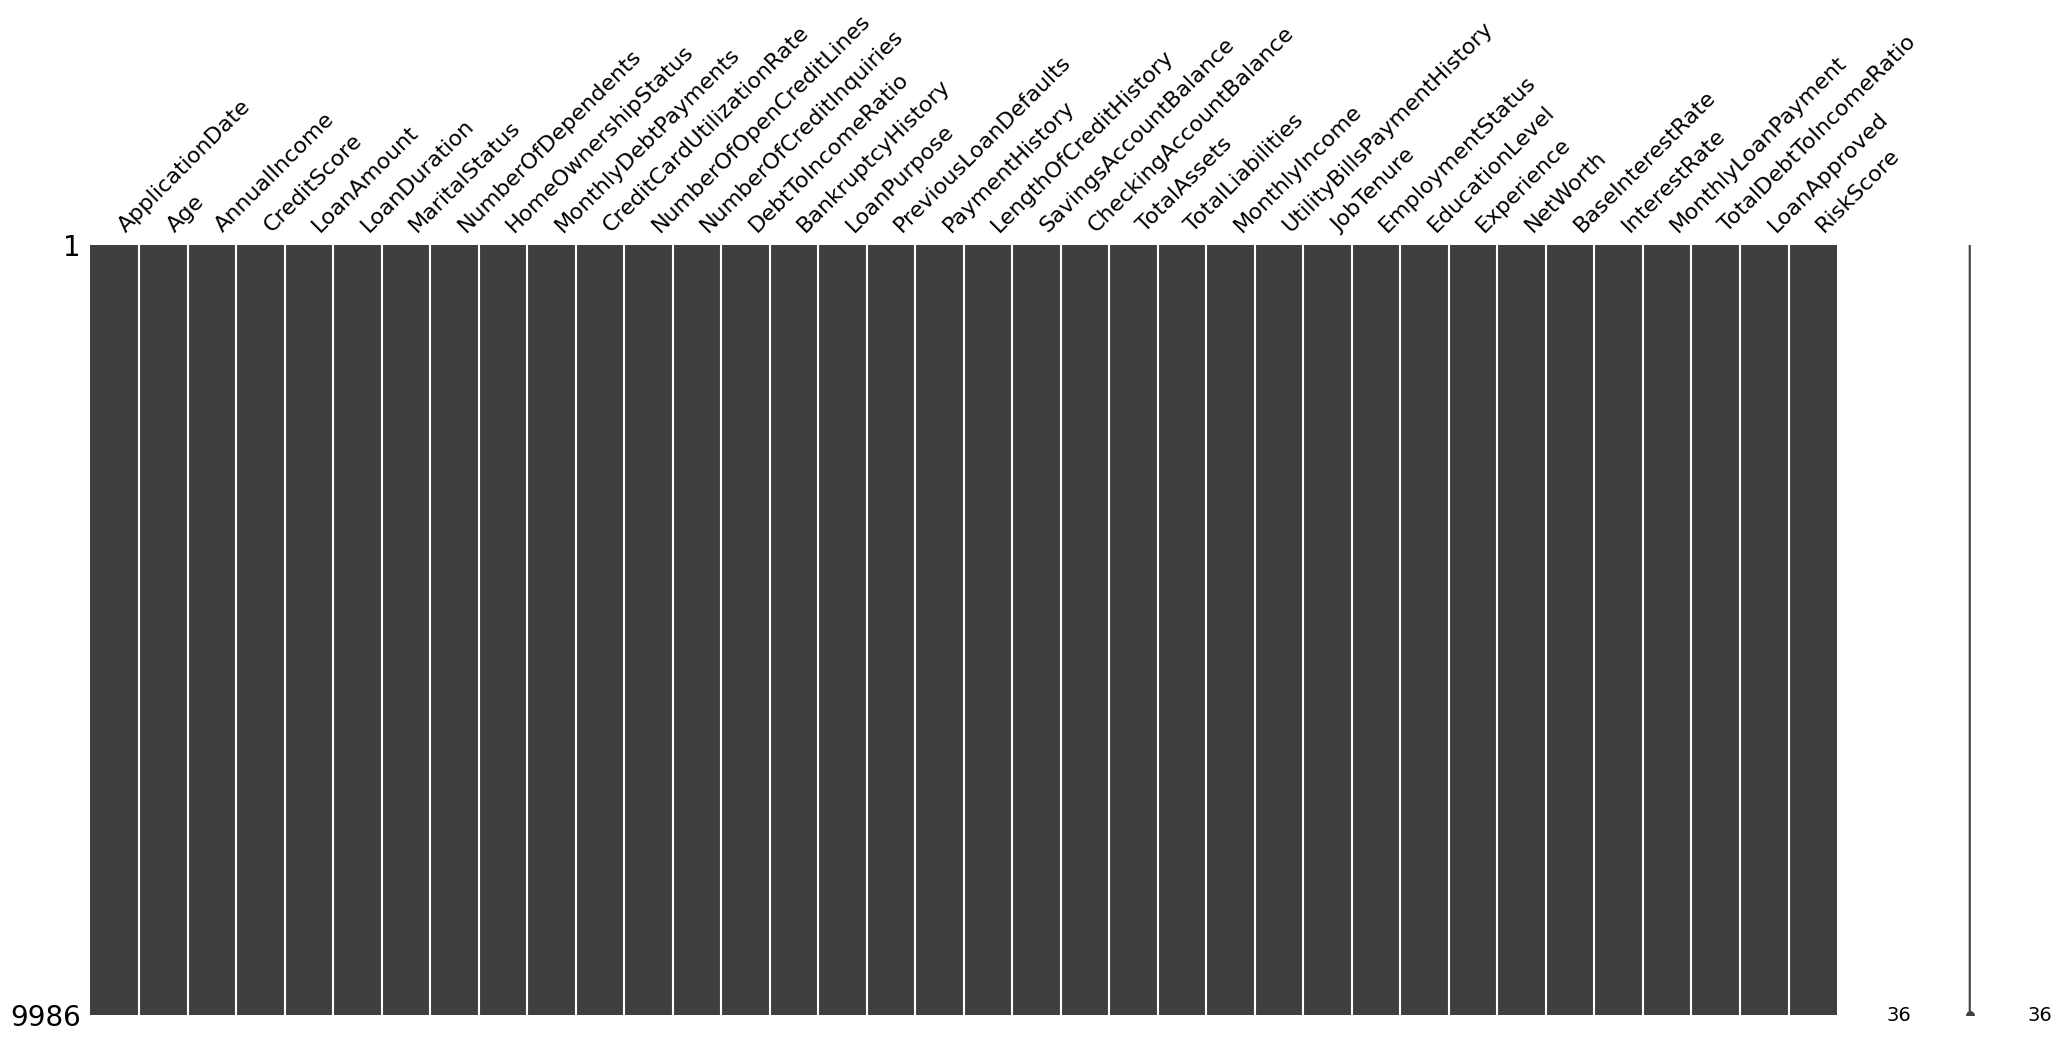

In [209]:
import missingno as msno

table = table.dropna(how='any')

msno.matrix(table)


Теперь рассмотрим "предсказываемую" колонку Riskscore на наличие выбросов. Для наглядности построим гистограмму значений.

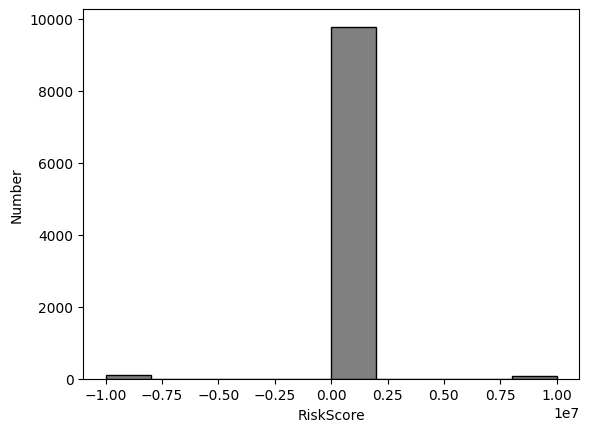

In [210]:
plt.hist(table['RiskScore'], color='gray', edgecolor='black',)
plt.xlabel('RiskScore')
plt.ylabel('Number')
plt.show()

Как видно по гистограмме, в колонке присутствует небольшое количество выбросов с аномальными значениями. Их необходимо удалить, чтобы они не повлияли на предсказания.

In [211]:
risk_cond = (table['RiskScore'] > 0) & (table['RiskScore'] < 0.75 * 1e7)
table = table.drop(table[~(risk_cond)].index)

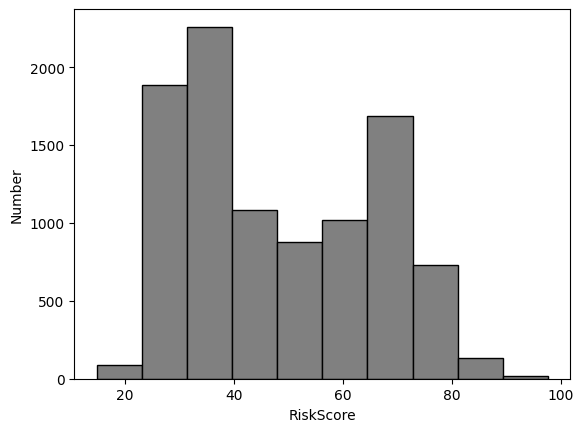

In [212]:
plt.hist(table['RiskScore'], color='gray', edgecolor='black',)
plt.xlabel('RiskScore')
plt.ylabel('Number')
plt.show()

Теперь значения Riskscore нормальные и можно приступить к анализу других признаков. Для наглядности построим графики зависимости Riskscore от всех числовых признаков.

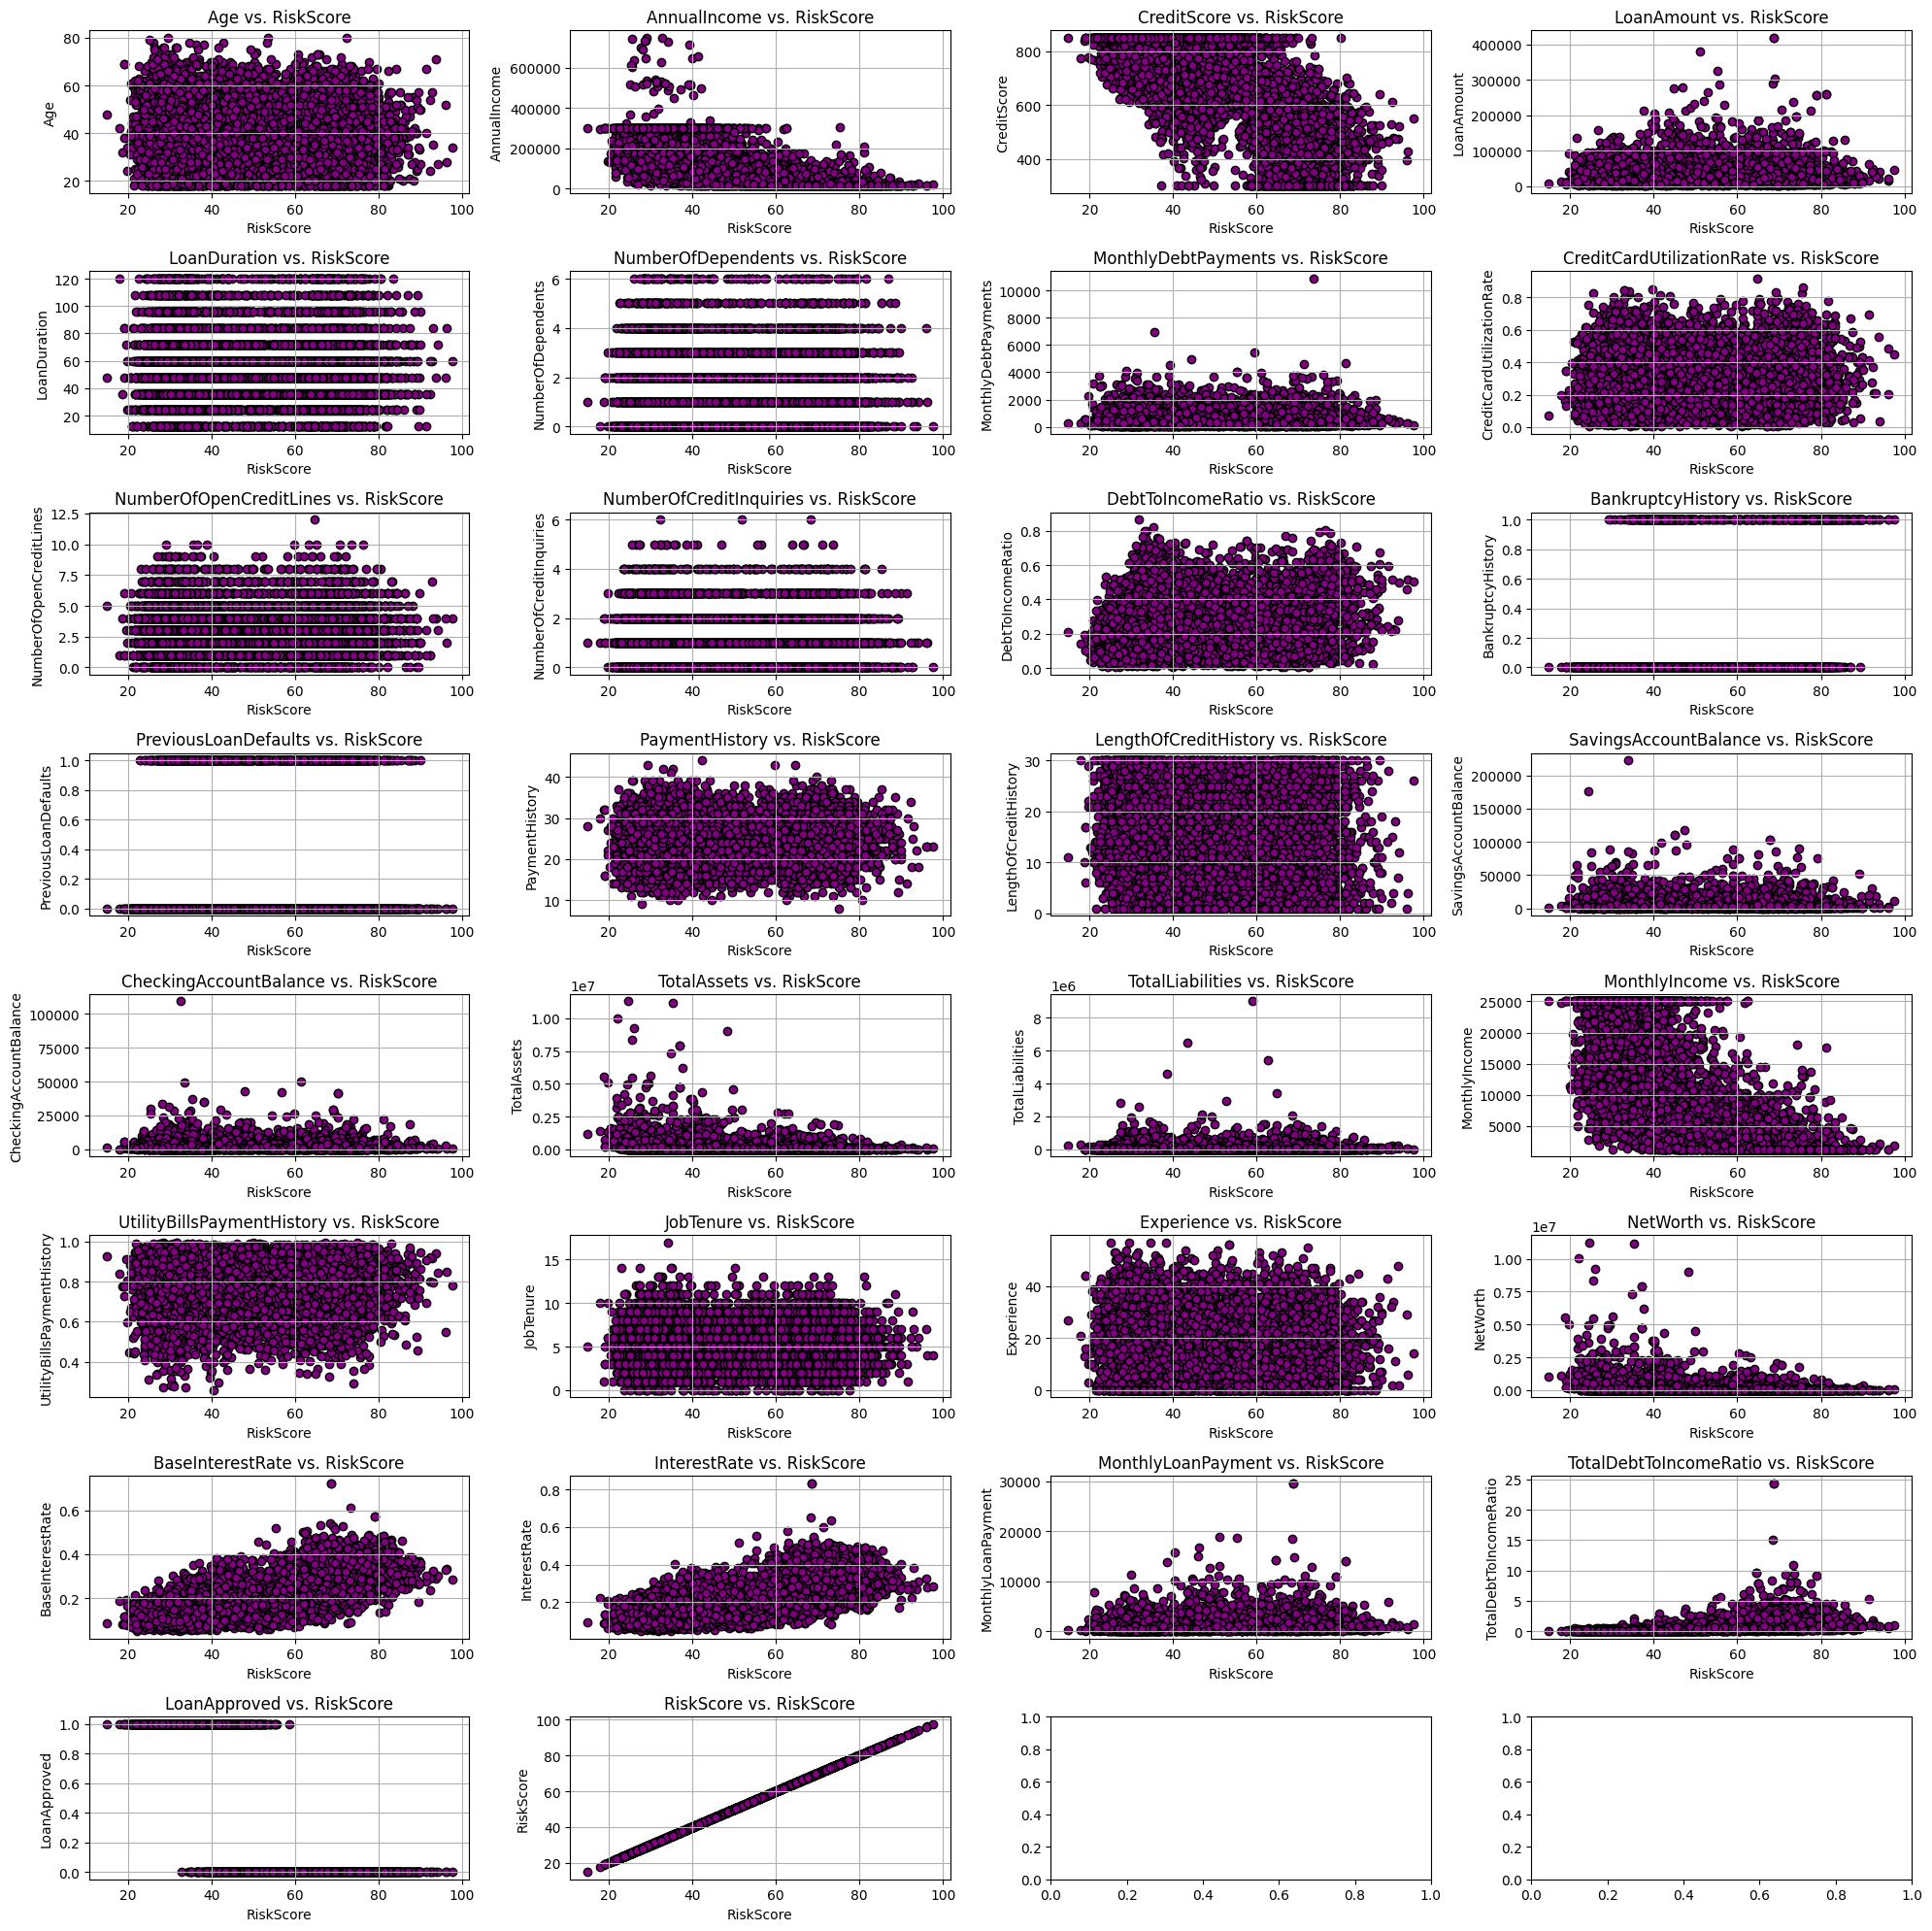

In [213]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 20)) 

int_columns = []

risk = table['RiskScore']

for x in table.columns:
    if not(type(table[x][1]) == str):
        int_columns.append(x)

for i, col in enumerate(int_columns):

    row = i // 4
    col_idx = i % 4
    ax = axes[row, col_idx]

    ax.scatter(risk, table[col], color='purple', edgecolors='black')
    ax.set_title(f'{col} vs. RiskScore')
    ax.set_xlabel('RiskScore')
    ax.set_ylabel(f'{col}')
    ax.grid(True)

plt.tight_layout() 
plt.show()


Видим некоторые линейные зависимости - это сильные признаки, которые будут лежать в основе предсказания. Для большей наглядности также построим их корреляционную матрицу.

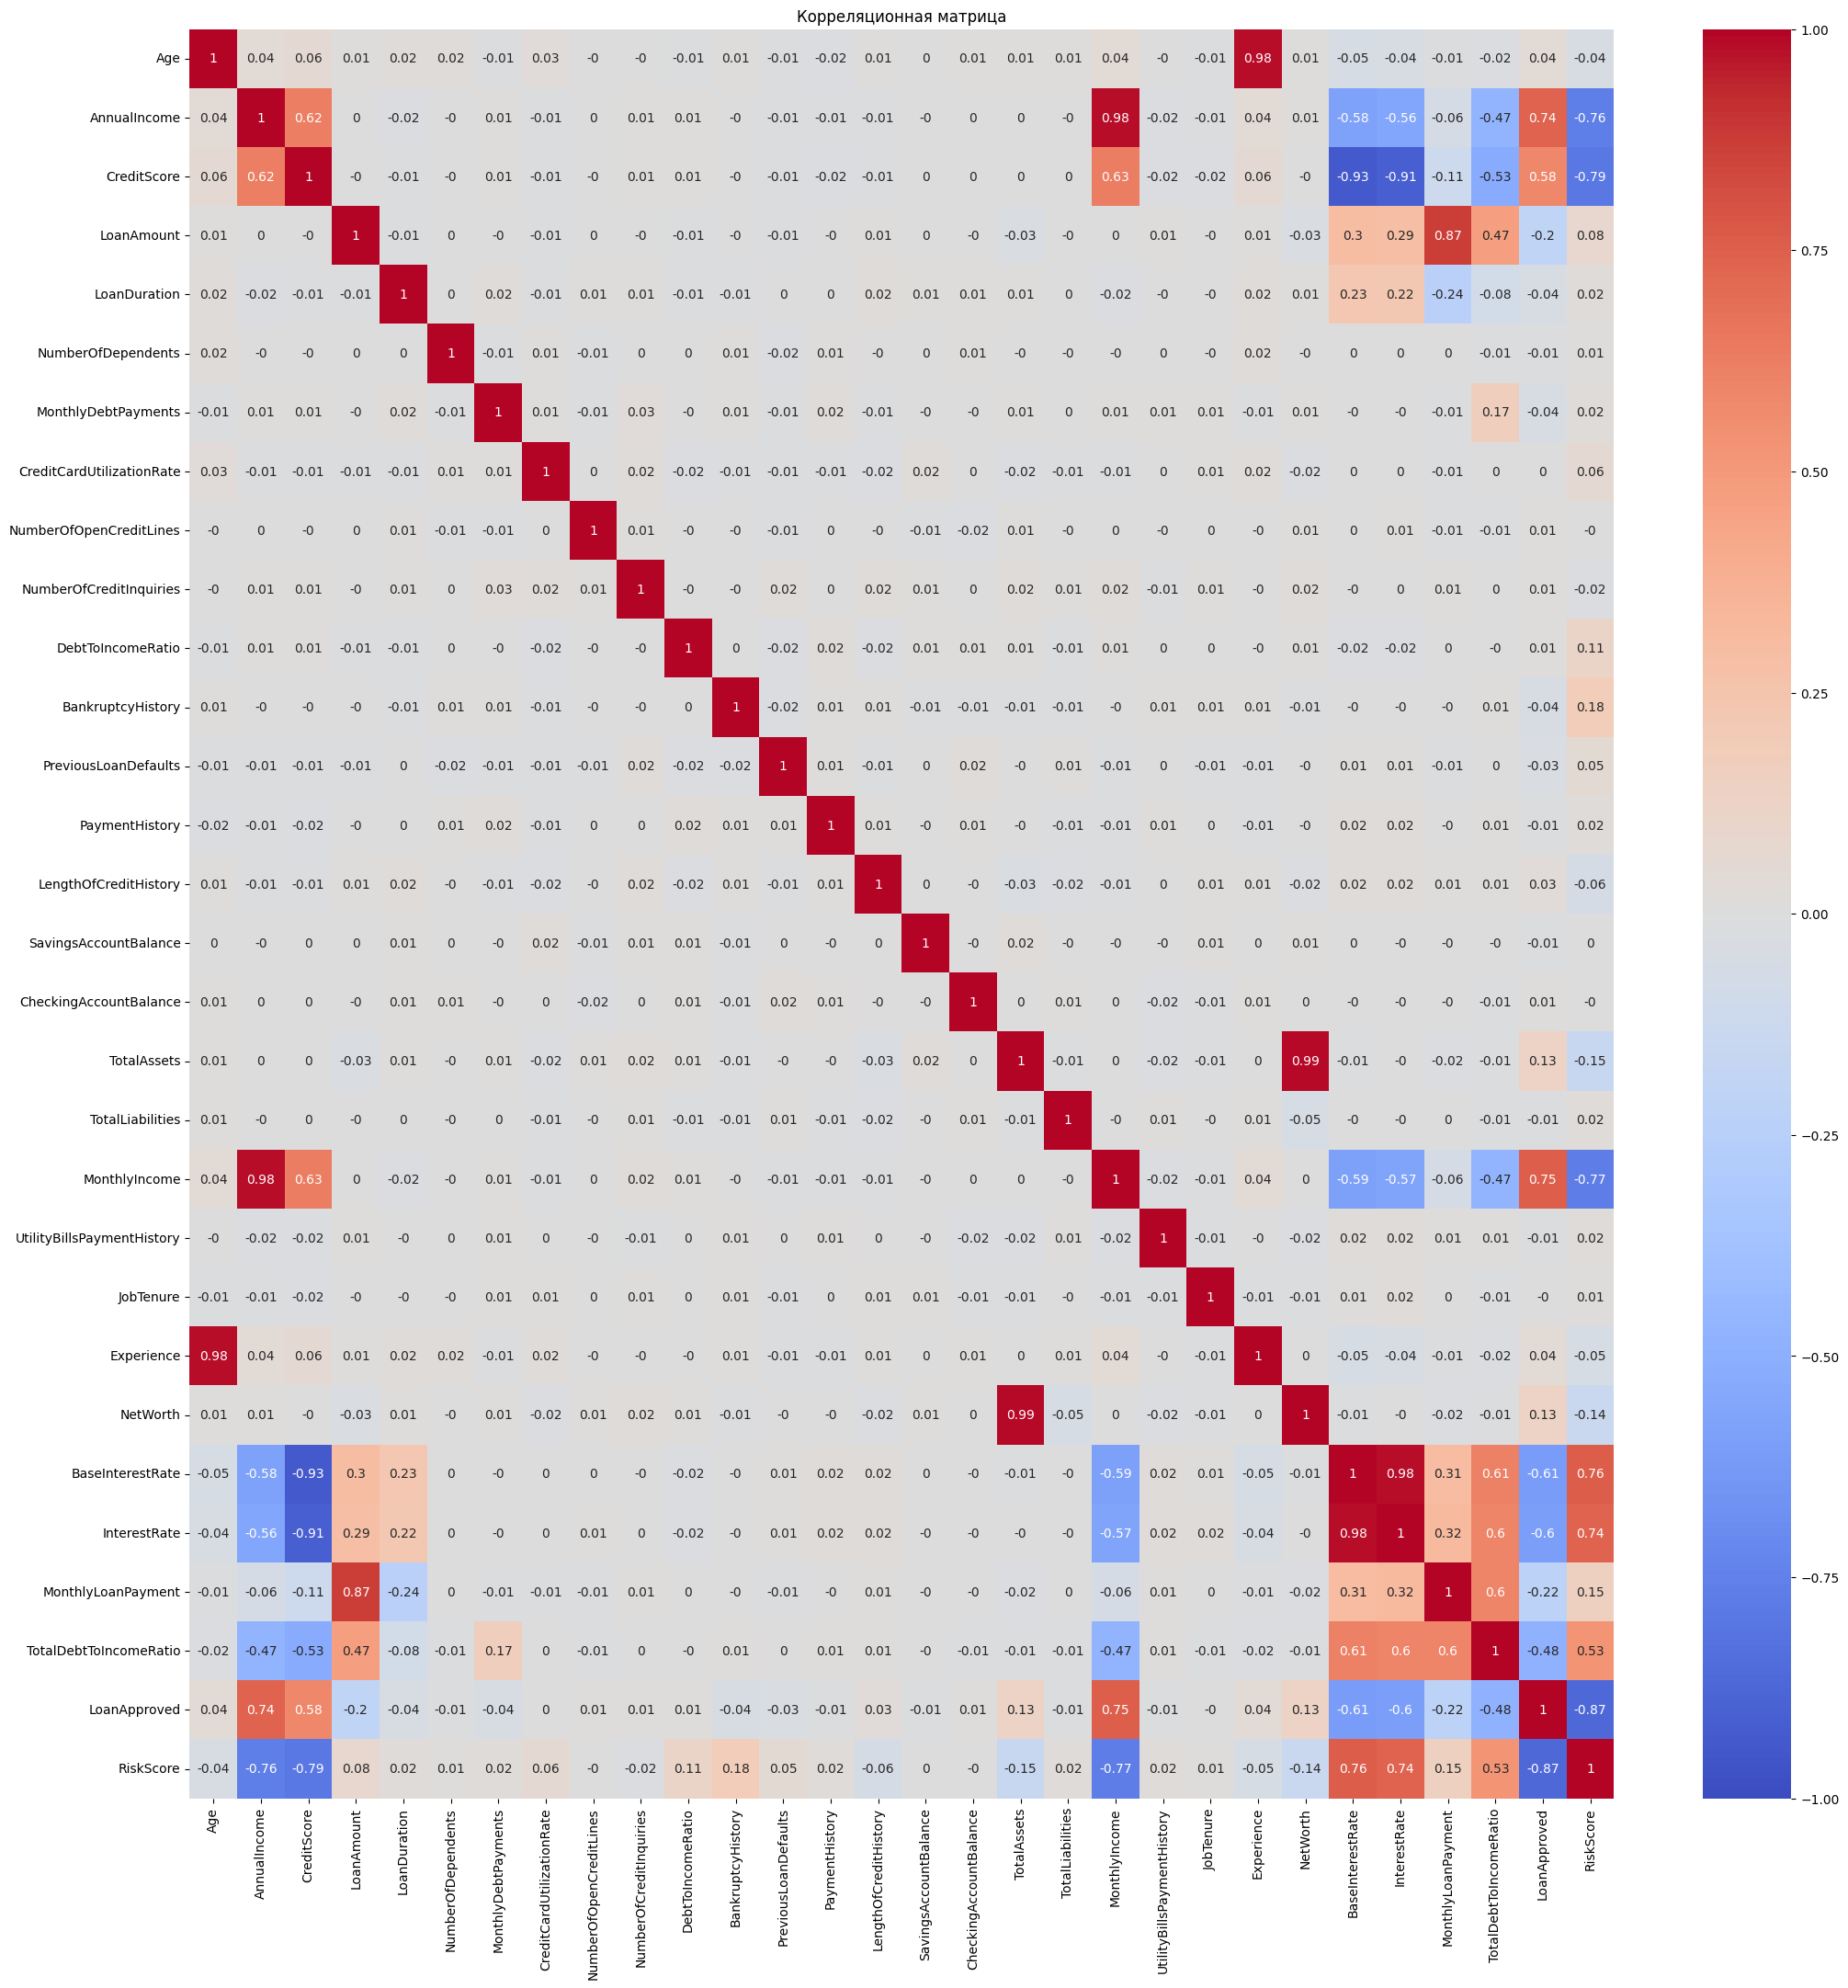

In [214]:
corr_mtrx = table[int_columns].dropna().corr().round(2)

plt.figure(figsize=(25, 25))
sns.heatmap(corr_mtrx, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляционная матрица")
plt.show()

Она получилась слишком большой за счёт многих признаков, не зависящих друг от друга никак. Выберем только сильно зависящие признаки.

In [215]:
high_corr = corr_mtrx[((corr_mtrx < -0.75) | (corr_mtrx > 0.75)) & (corr_mtrx < 1)].stack()

high_corr

Age                 Experience            0.98
AnnualIncome        MonthlyIncome         0.98
                    RiskScore            -0.76
CreditScore         BaseInterestRate     -0.93
                    InterestRate         -0.91
                    RiskScore            -0.79
LoanAmount          MonthlyLoanPayment    0.87
TotalAssets         NetWorth              0.99
MonthlyIncome       AnnualIncome          0.98
                    RiskScore            -0.77
Experience          Age                   0.98
NetWorth            TotalAssets           0.99
BaseInterestRate    CreditScore          -0.93
                    InterestRate          0.98
                    RiskScore             0.76
InterestRate        CreditScore          -0.91
                    BaseInterestRate      0.98
MonthlyLoanPayment  LoanAmount            0.87
LoanApproved        RiskScore            -0.87
RiskScore           AnnualIncome         -0.76
                    CreditScore          -0.79
             

Заметим, что среди признаков, от которых Riskscore зависит наиболее сильно, есть как минимум пара признаков, зависящих друг от друга практически напрямую - это MonthlyIncome и AnnualIncome. От признака MonthlyIncome избавляемся.

In [216]:
high_corr = high_corr.drop(labels='MonthlyIncome', level=0)
high_corr = high_corr.drop(labels='MonthlyIncome', level=1)

int_columns.remove('MonthlyIncome')

high_corr

Age                 Experience            0.98
AnnualIncome        RiskScore            -0.76
CreditScore         BaseInterestRate     -0.93
                    InterestRate         -0.91
                    RiskScore            -0.79
LoanAmount          MonthlyLoanPayment    0.87
TotalAssets         NetWorth              0.99
Experience          Age                   0.98
NetWorth            TotalAssets           0.99
BaseInterestRate    CreditScore          -0.93
                    InterestRate          0.98
                    RiskScore             0.76
InterestRate        CreditScore          -0.91
                    BaseInterestRate      0.98
MonthlyLoanPayment  LoanAmount            0.87
LoanApproved        RiskScore            -0.87
RiskScore           AnnualIncome         -0.76
                    CreditScore          -0.79
                    BaseInterestRate      0.76
                    LoanApproved         -0.87
dtype: float64

In [217]:
risk_corr = high_corr[high_corr.index.get_level_values(0) == 'RiskScore']

risk_corr = list(risk_corr.index.get_level_values(1))

risk_corr

['AnnualIncome', 'CreditScore', 'BaseInterestRate', 'LoanApproved']

Отберем отдельно категориальные признаки.

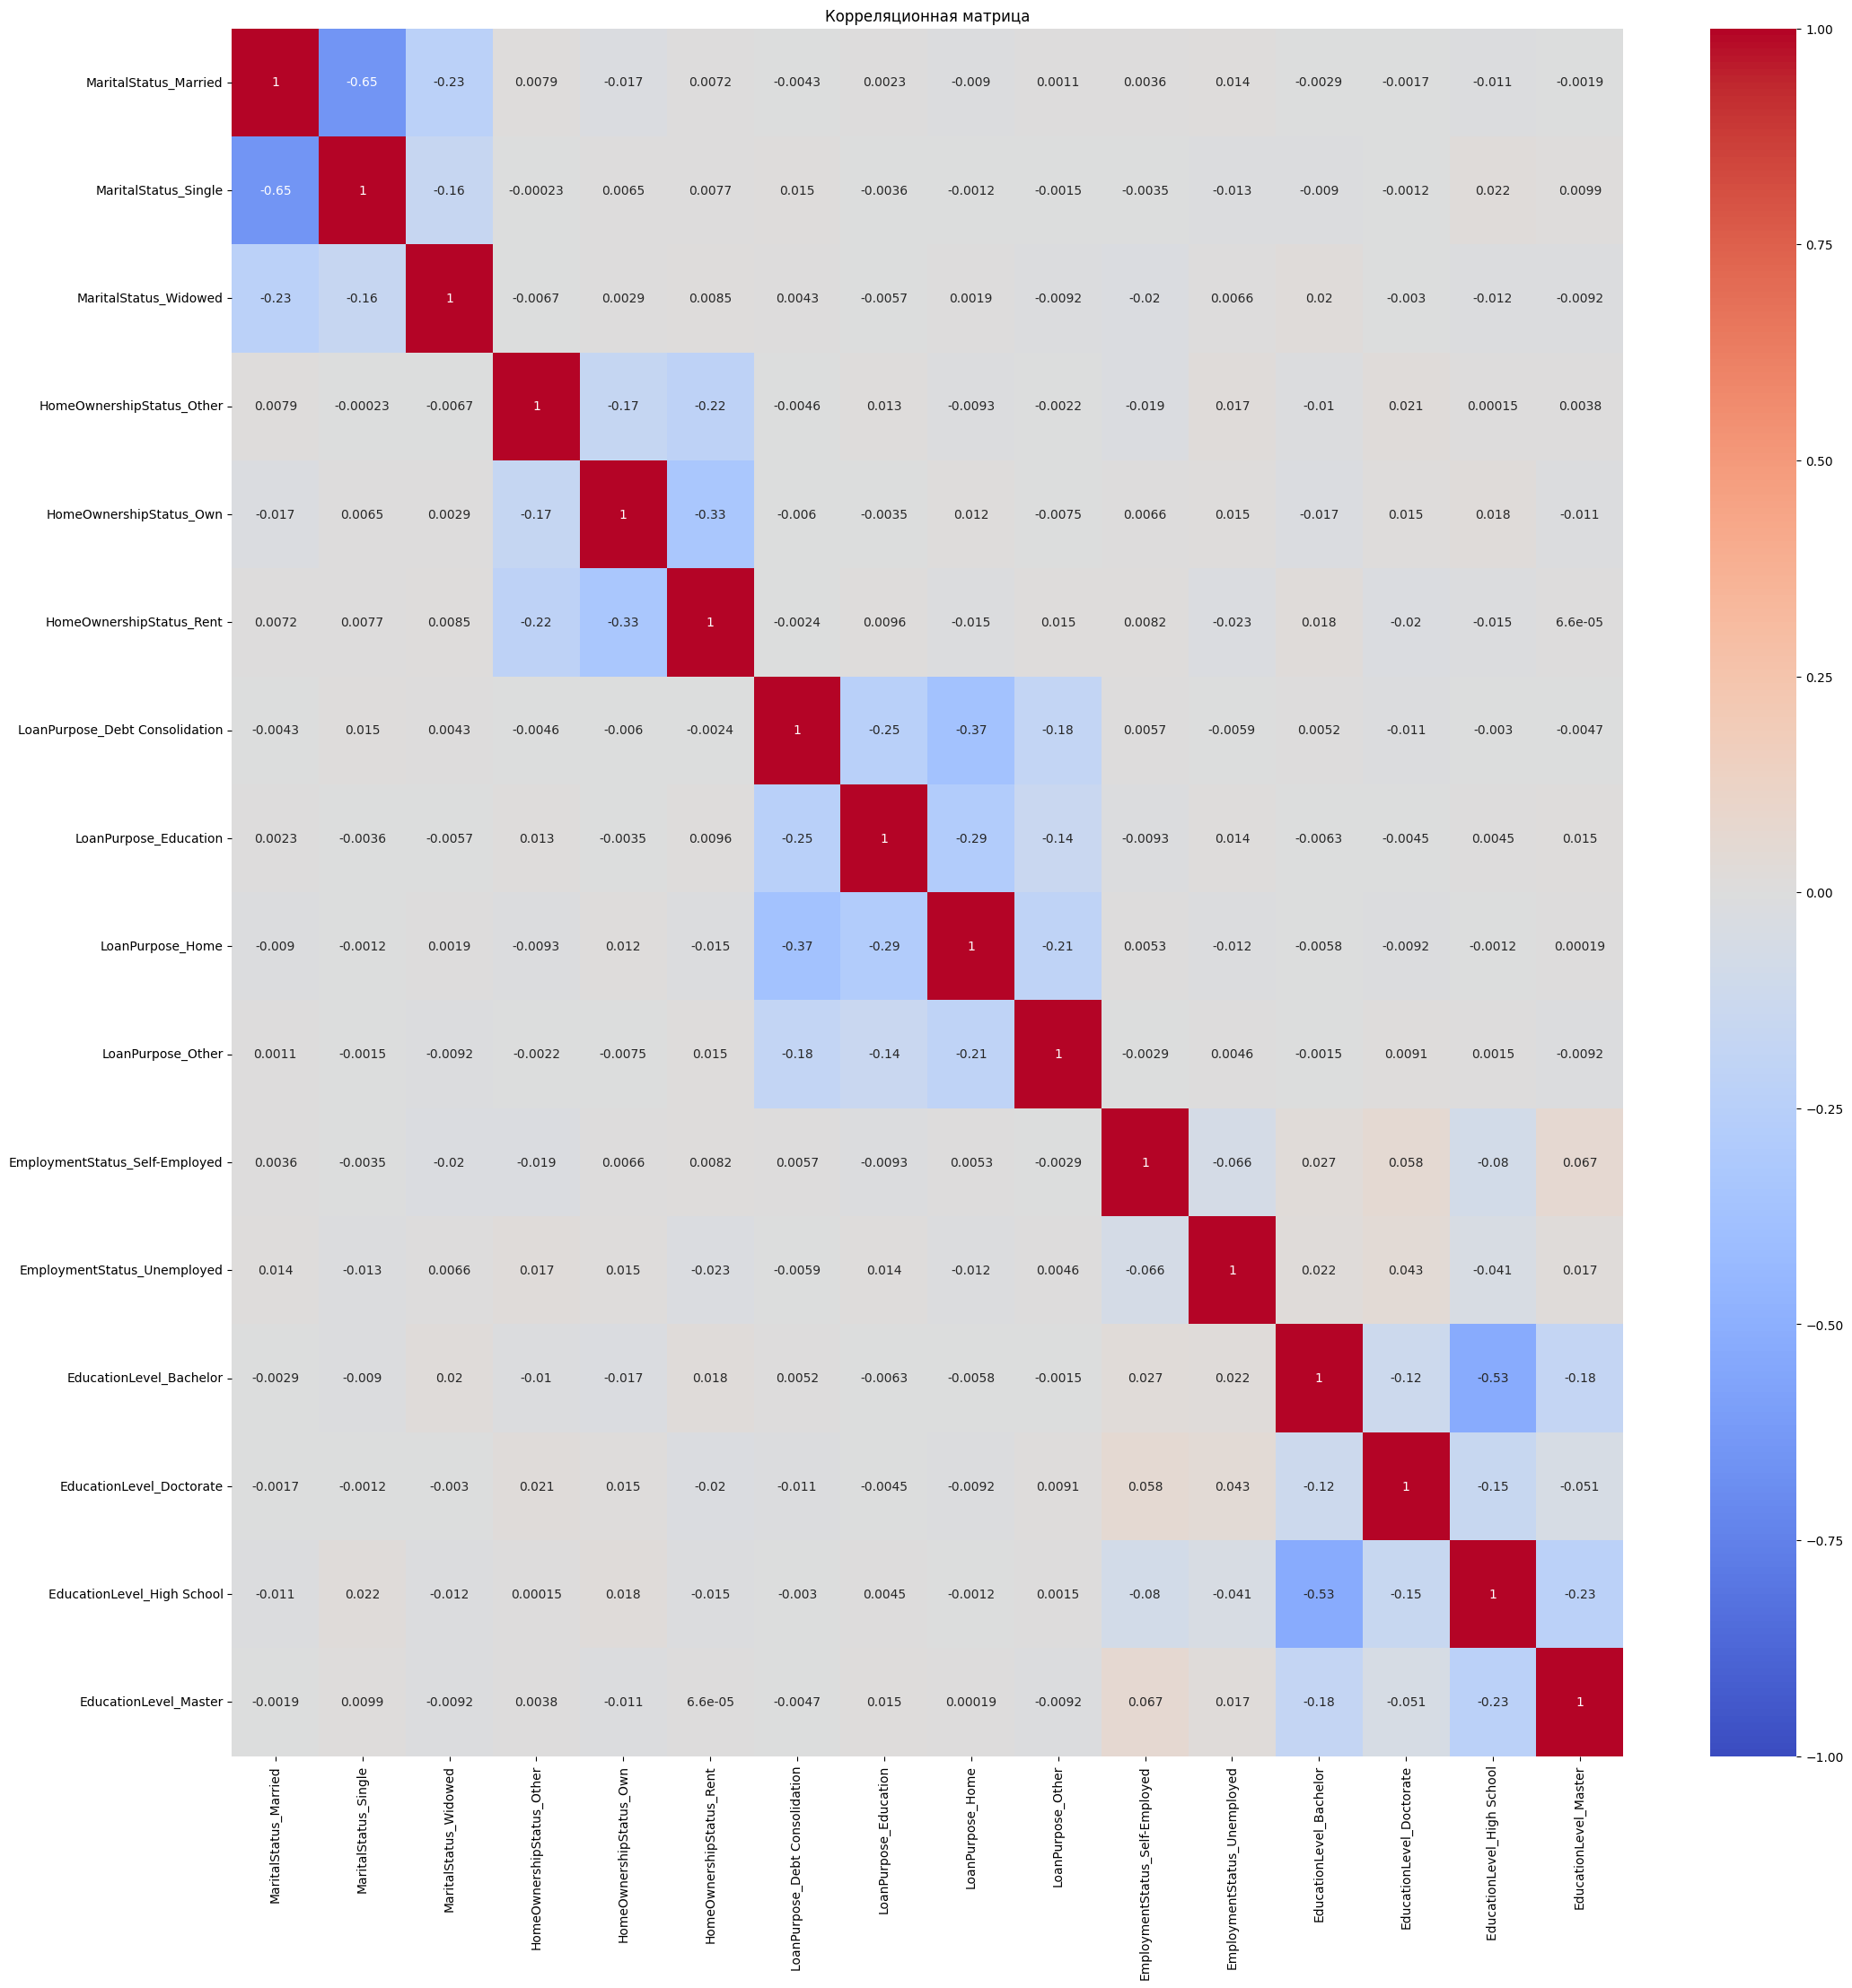

In [218]:
ctgrl_pr = []
mp_ctgrl = {}

for x in table.columns:
    if (type(table[x][1]) == str):
        ctgrl_pr.append(x)

ctgrl_pr.remove('ApplicationDate')

for x in ctgrl_pr:
    mp_ctgrl[x] = table[x]

df_mp_ctgrl = pd.DataFrame(mp_ctgrl)
df_mp_ctgrl = pd.get_dummies(df_mp_ctgrl, columns=ctgrl_pr, drop_first=True)
ctgrl_corr = df_mp_ctgrl.corr()

plt.figure(figsize=(25, 25))
sns.heatmap(ctgrl_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляционная матрица")
plt.show()

Тем не менее было решено пока не использовать категориальные признаки для предсказания Riskscore и временно ограничиться только числовыми, за исключением некоторых. 

In [219]:
final_cats = int_columns

table = table[final_cats]
table.head()

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,UtilityBillsPaymentHistory,JobTenure,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,27.0,66829.0,549.0,17290.0,60.0,1.0,1095.0,0.151985,2.0,1.0,...,0.908289,4.0,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,55.0,172147.0,850.0,16110.0,36.0,1.0,211.0,0.175693,3.0,0.0,...,0.797339,2.0,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,51.0,300000.0,850.0,38436.0,36.0,0.0,546.0,0.444605,3.0,0.0,...,0.915945,3.0,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,25.0,34683.0,847.0,19186.0,48.0,0.0,153.0,0.188452,7.0,0.0,...,0.876416,3.0,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,55.0,300000.0,850.0,30437.0,48.0,2.0,562.0,0.273431,3.0,1.0,...,0.888689,5.0,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091


Попробуем создать модель линейной регрессии. Импортируем необходимые библиотеки

In [220]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

Далее разделим датасет на две таблицы:

In [221]:
X = table.drop(columns= ['RiskScore']) # Таблица признаков
y = table['RiskScore'] # Колонка с предсказываемой переменной

Разделим данные на обучающую и тестовую выборки (20% тестовых данных и 80% тренировочных):

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Осуществим нормализацию данных:

In [223]:
scaler = StandardScaler() # Объект StandartScaler

X_train_scaled = scaler.fit_transform(X_train) # Рассчёт параметров нормализации

X_test_scaled = scaler.transform(X_test) # Применение параметров нормализации 

Произведем обучение модели:

In [224]:
model = LinearRegression() # Объект модели линейной регресии

model.fit(X_train_scaled, y_train) # Обучение модели на уже нормализованных данных обучающей выборки

LinearRegression()

Получим результат и сравним его с верным, рассчитав среднеквадратичную оценку MSE:

In [225]:
y_pred = model.predict(X_test_scaled) # Получаем массив предсказанных значений

mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

Mean Squared Error: 20.859535748688508


Обработаем тестовый датасет, предварительно удалив из нашего массива признаков колонку RiskScore, которой нет в тестовом датасете

In [226]:
test_data = pd.read_csv('test.csv')
final_cats.remove('RiskScore')

In [227]:
X_test = test_data[final_cats] # Фрейм, содержащий тестовые данные выбранных признаков
X_test_scaled = scaler.transform(X_test) # Масштабируем тестовые данные с использованием тех же параметров, что и на обучающей выборке при помощи

y_pred_test = model.predict(X_test_scaled) # Предсказание значений целевой переменной

results = pd.DataFrame({'ID' : test_data['ID'], 'RiskScore': y_pred_test}) # Итоговый датафрейм

results.to_csv('submission.csv', index=False) # Запишем его в файл csv